Este script genera una raster plot para un trial dado. En el raster plot se dibujan las DOEs en cada linea una prendida del objeto 1 segundo antes de prender y los 5 segundos de prendido del objeto.

Toma los archivos .bin de las DOEs y el csv que registra las timestamps de los prendidos. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
from datetime import datetime, timedelta
from scipy.spatial import distance

data_folder = r'D:\Datos G. omarorum\Fish1\Objeto\Trial 1 y 2\raw' #cambiar a ruta con archivos .bin
os.chdir(data_folder)
files_vid = sorted(glob.glob('*.h5'))
on_off = pd.read_csv(r"D:\Datos G. omarorum\Fish1\Objeto\Trial 1 y 2\raw\on_off_trial1.csv", header=None) #archivo csv con las timestamps del objeto
files_EOD = sorted(glob.glob('*.bin'))

La siguiente celda genera la lista 'files_start' que guarda los timestamps de los comienzos de cada archivo de DOEs en la carpeta. 

In [2]:
with open('fish1_FB-DOE.pkl', 'rb') as file:  
        FB_doe = pickle.load(file)

In [4]:
FB_doe['Peak-time']['2024-01-05T17_02_50.']

array([     173,      449,      723, ..., 11997695, 11997974, 11998252],
      dtype=int64)

In [57]:
files_start = []
for i in range(len(FB_doe['FB-DOE'].keys())):
    files_start.append(datetime.strptime(list(FB_doe['FB-DOE'].keys())[i][:-1], '%Y-%m-%dT%H_%M_%S'))

La siguiente celda convierte los tiempos de on-off a timestamps  

In [58]:
for i in range(on_off.shape[0]):
    on_off.iloc[i,0] = datetime.fromisoformat(on_off.iloc[i,0][:-6])  # Removing the microseconds for compatibility

on_off = on_off.drop(on_off.columns[[1,2]], axis=1)

A continuacion seleccionamos los archivos durante los cuales se enciende el objeto

In [59]:
n=0
for i in range(len(files_start)):
    delta = (files_start[i] - on_off.iloc[-1,0]).total_seconds()
    if delta < 0:
        n += 1

FB_DOE = FB_doe['FB-DOE']
Peak_time = FB_doe['Peak-time']

keys = list(FB_doe['FB-DOE'].keys())[n-1:]
for key in keys:
    FB_DOE.pop(key, None)
    Peak_time.pop(key, None)

files_vid = files_vid[:n-1]


La siguiente celda reformula la lista de archivos a un Dataframe cuyas columnas son el numero (indice) de on que se prende en cada archivo 

In [60]:
#on_off = on_off.iloc[2:].reset_index()

In [61]:
on_off[0][49]

datetime.datetime(2024, 1, 5, 20, 22, 59, 482828)

In [62]:
files = pd.DataFrame(np.zeros(shape=(5,len(FB_DOE.keys()))), columns=list(FB_DOE.keys()))
for i in range(n-1):
    start = files_start[i]
    e = i+1
    end = files_start[e]
    for j in range(len(on_off)):        
        condicion = (start - on_off[0][j]).total_seconds() < 0 and (end - on_off[0][j]).total_seconds() > 0 
        if condicion:
            files.iloc[j-(5*i), i] = j

files.replace(0, np.nan, inplace=True) # como inicializamos con una matriz de 0s, si hay algun archivo con menos de 5 ons vamos a tener 0s donde no deben haber, entonces los convertimos a nan
files.iloc[0,0] = 0 # el primer objeto tiene que ser un 0
for col in list(files.keys()): #este codigo es para asegurarnos que hayan quedado los numeros de on en orden
    files[col] = sorted(files[col])
files

,2024-01-05T17_02_50.,2024-01-05T17_22_50.,2024-01-05T17_42_50.,2024-01-05T18_02_50.,2024-01-05T18_22_51.,2024-01-05T18_42_51.,2024-01-05T19_02_51.,2024-01-05T19_22_51.,2024-01-05T19_42_51.,2024-01-05T20_02_51.,2024-01-05T20_22_51.,2024-01-05T20_42_52.
0,0.0,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,49.0,54.0
1,1.0,6.0,11.0,16.0,21.0,26.0,31.0,36.0,41.0,46.0,50.0,55.0
2,2.0,7.0,12.0,17.0,22.0,27.0,32.0,37.0,42.0,47.0,51.0,56.0
3,3.0,8.0,13.0,18.0,23.0,28.0,33.0,38.0,43.0,48.0,52.0,57.0
4,4.0,9.0,14.0,19.0,24.0,29.0,34.0,39.0,44.0,NaN,53.0,58.0


La finalidad de la siguiente celda es generar tres listas: time_EOD_all, time_obj_all y EOD_peaks_on. Estas listas contienen en cada elemento el tiempo de la EOD, el tiempo donde el obj esta prendido y los picos de la DOE, respectivamente, para cada prendida de objeto. 

In [72]:
EOD_peaks_on = []
time_EOD_all  = []
time_obj_all = []
EOD_f_on = []

for k in range(len(files.keys())): #loopeamos entre los archivos de interes
    midnight = files_start[k].replace(hour=0, minute=0, second=0, microsecond=0) #definimos la media noche para el dia donde se registro ese archivo
    start = abs(midnight - files_start[k]).total_seconds() # calculamos el tiempo de inicio del archivo en segundos totales respecto de las 00 para poder compararla
    EOD = np.fromfile(files_EOD[k],dtype=np.int16)
    time_EOD = np.linspace(start=start, stop=start+(20*60), num=len(EOD))
    del EOD
    EOD_peaks = Peak_time[list(Peak_time.keys())[k]]
    EOD_freq = np.array(FB_DOE[list(FB_DOE.keys())[k]])
    time_obj = np.zeros((1,5)) #inicializamos nuestra matriz de tiempo de prendida de obj (cada archivo puede tener maximo 5 ons, por eso las dimensiones)
    
    l = 0
    for i in files.iloc[:,k]: 
           if not np.isnan(i):
                s = abs(midnight - on_off[0][int(i)]).total_seconds() #calculamos el inicio del on
                time_obj[0,l] = s
                time_obj_all.append(s) #guardamos el tiempo de este on en nuestra lista de tiempos de objeto
                time_EOD_all.append(time_EOD) #guardamos una copia de time_EOD para cada on 
                l += 1

    for j in range(time_obj.shape[1]):
        range_on = [time_obj[0,j]-0.5, time_obj[0,j]+10] #definimos el rango de interes: 1/2 segundo antes que sea el on y 2 segundos despues
        
        time_peaks = time_EOD[EOD_peaks]
        condition = [range_on[0] <= time <= range_on[1] for time in time_peaks]

        EOD_peaks_on.append(EOD_peaks[condition])
        EOD_f_on.append(EOD_freq[condition[:-1]])
  

    print('termino archivo ' + str(k))


termino archivo 0
termino archivo 1
termino archivo 2
termino archivo 3
termino archivo 4
termino archivo 5
termino archivo 6
termino archivo 7
termino archivo 8
termino archivo 9
termino archivo 10
termino archivo 11


En la siguiente celda graficamos el raster plot 

In [73]:
import matplotlib.cm as cm
colormap = cm.get_cmap('Blues')
colors = [colormap(i+100) for i in range(len(time_obj_all))]

/var/folders/dk/0fvz37fn27l9149spycxsyf80000gp/T/ipykernel_62896/1892143129.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues')


In [74]:
i_to_pop = [49]
for i in i_to_pop:
    EOD_peaks_on.pop(i)
    EOD_f_on.pop(i)


In [75]:
freq_stack = np.vstack([np.pad(lst, (0, max(map(len, EOD_f_on)) - len(lst)), 'constant') for lst in EOD_f_on])
freq_stack[freq_stack == 0] = np.nan
medians = np.nanmedian(freq_stack, axis=0)
medians

array([37.03703395, 37.59398183, 37.45349251, ..., 49.50535891,
       49.50535891, 50.50546717])

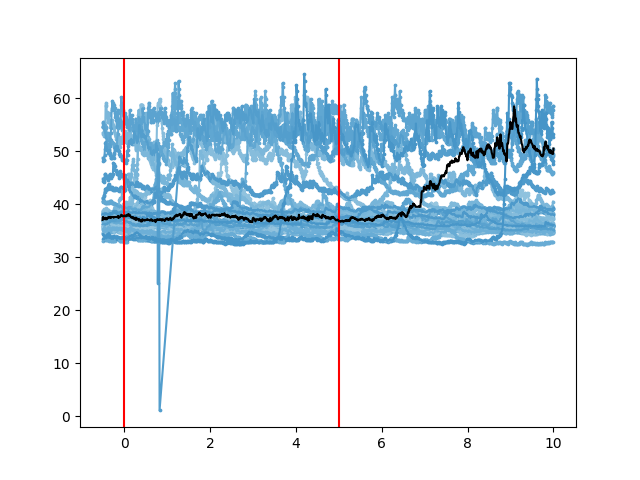

In [77]:
%matplotlib widget
plt.figure()

for time_EOD, EOD_peaks, time_obj, EOD_f, color in zip(time_EOD_all, EOD_peaks_on, time_obj_all, EOD_f_on,colors):
    x = time_EOD[EOD_peaks] - time_obj
    y = EOD_f
    
    if len(x) == len(y):  # Check if there are elements satisfying the condition?
        plt.scatter(x, y, s=2.85, color=color)
        plt.plot(x, y, color=color)

plt.axvline(x=0, color='red', linestyle='-', label='Vertical Line')
plt.axvline(x=5, color='red', linestyle='-', label='Vertical Line')
plt.plot(np.linspace(-.5, 10, len(medians)), medians, color='k')
plt.show()

In [ ]:
print(len(time_EOD_all[0]), len(EOD_peaks_on[0]), time_obj_all[0], len(EOD_f_on[0]))

In [ ]:
colors